In [1]:
import numpy as np
import pandas as pd
import pickle as pkl 
import xarray as xr
import copy
import os
import sys 
import metrics
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import kstest
import pylab 
import scipy.stats as stats
from numpy.linalg import LinAlgError
from IPython.display import clear_output
print("XArray version: ", xr.__version__)
colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']

XArray version:  0.16.1


In [2]:
##########################################################################################################
# LOAD IN THE DATA
##########################################################################################################
with open('./model_output_for_analysis/nwm_chrt_v2_1d_local.p', 'rb') as fb: 
    nwm_results = pkl.load(fb)

lstm_results_time_split1={}
mclstm_results_time_split1={}
sacsma_results_time_split1={}
lstm_results_time_split2={}
mclstm_results_time_split2={}
sacsma_results_time_split2={}

for forcing_type in ['nldas', 'daymet']:
    
    with open('./model_output_for_analysis/lstm_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb: 
        lstm_results_time_split1[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/mclstm_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb: 
        mclstm_results_time_split1[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/sacsma_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb: 
        sacsma_results_time_split1[forcing_type] = pkl.load(fb)

    with open('./model_output_for_analysis/lstm_time_split2_{}.p'.format(forcing_type), 'rb') as fb: 
        lstm_results_time_split2[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/mclstm_time_split2_{}.p'.format(forcing_type), 'rb') as fb: 
        mclstm_results_time_split2[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/sacsma_time_split2_{}.p'.format(forcing_type), 'rb') as fb: 
        sacsma_results_time_split2[forcing_type] = pkl.load(fb)

train_split_type_model_set = {'time_split1':{'nwm':nwm_results, 
                                           'lstm':lstm_results_time_split1,
                                            'mc':mclstm_results_time_split1,
                                            'sac':sacsma_results_time_split1},
                              'time_split2':{'nwm':nwm_results,
                                           'lstm':lstm_results_time_split2,
                                            'mc':mclstm_results_time_split2,
                                            'sac':sacsma_results_time_split2}}

In [3]:
##########################################################################################################
# USE A CONVERSION BETWEEN MODELS AND DATA
##########################################################################################################
# Convert flow to   CFS mm -> ft     km^2 -> ft^2    hr->s
conversion_factor = 0.00328084 * 10763910.41671 / 3600 / 24

In [4]:
##########################################################################################################
# Get all the CAMELS attributes.  
##########################################################################################################

# Camels attributes with RI information
dataName = '../data/camels_attributes.csv'
# load the data with pandas
pd_attributes = pd.read_csv(dataName, sep=',', index_col='gauge_id')

# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in pd_attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
pd_attributes['basin_id_str'] = basin_id_str

In [5]:
##########################################################################################################
# Loop through all the SACSMA runs and check that the results are good. 
# Get a list of basins that has good calibration results.
##########################################################################################################
basin_list_all_camels = list(pd_attributes['basin_id_str'].values)
basin_list_sacsma_good = {ts:copy.deepcopy(basin_list_all_camels) for ts in ['time_split1', 'time_split2']}

for ib, basin_0str in enumerate(basin_list_all_camels): 
    remove_basin_id_from_list = False
    for train_split_type in ['time_split1', 'time_split2']:
        for forcing_type in ['nldas', 'daymet']:

            if basin_0str not in list(train_split_type_model_set[train_split_type]['sac'][forcing_type].columns):
                remove_basin_id_from_list = True
            elif train_split_type_model_set[train_split_type]['sac'][forcing_type][basin_0str].sum() <=0:
                remove_basin_id_from_list = True

            if train_split_type == 'time_split2' and forcing_type == 'nldas':
                if basin_0str not in list(train_split_type_model_set[train_split_type]['nwm'].keys()):
                    remove_basin_id_from_list = True

    if remove_basin_id_from_list:
        basin_list_sacsma_good[train_split_type].remove(basin_0str)

In [6]:
##########################################################################################################
#-------------------------------------------------------------------------------------------------
# Solve this problem. I think it is the xarray structures...
# isibleDeprecationWarning: Creating an ndarray from ragged nested sequences 
# (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. 
# If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
##########################################################################################################
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [7]:
##########################################################################################################
# REVERT TO THESE AS THE FLOWS
##########################################################################################################
flows = ['lstm', 'mc', 'sac', 'obs']


In [8]:
def get_specifications(tsplt, forcing_type):
    """
    This function is designed to return specific details of the simulation period
    Inputs:
        tsplit (str): Either time_split2 or time_split1
        forcing_type (str): Either nldas or daymet
    Returns
        start_date (pd.Timestamp): The date the simulation period started
        end_date (pd.Timestamp): The date the simulation period ended
        labelz (dictionary): A mapping between short model name and long model name
        models (list): the short model names
        flows (list): the short model names plus "obs" for observed flow
        basin_list (list): the list of basins that meet the criteria for analysis
        tsplit (str): Either time_split2 or time_split1
        forcing_type (str): Either nldas or daymet
    """
    if tsplt == 'time_split2' and forcing_type == 'nldas':
        start_date = pd.Timestamp('1996-10-01')
        end_date = pd.Timestamp('2014-01-01')
        labelz={'nwm':'NWM*', 'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
        models = ['nwm', 'lstm', 'mc', 'sac']
        flows = ['nwm', 'lstm', 'mc', 'sac', 'obs']
        basin_list = list(lstm_results_time_split2[forcing_type].keys())[:-1]
    elif tsplt == 'time_split2':
        start_date = pd.Timestamp('1996-10-01')
        end_date = pd.Timestamp('2014-01-01')
        labelz={'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
        models = ['lstm', 'mc', 'sac']
        flows = ['lstm', 'mc', 'sac', 'obs']
        basin_list = list(lstm_results_time_split2[forcing_type].keys())[:-1]
    else:
        start_date = pd.Timestamp('1989-10-01')
        end_date = pd.Timestamp('1999-09-30')
        labelz={'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
        models = ['lstm', 'mc', 'sac']
        flows = ['lstm', 'mc', 'sac', 'obs']
        basin_list = list(lstm_results_time_split1[forcing_type].keys())[:-1]

    spex = {"start_date":start_date,
            "end_date":end_date,
            "labelz":labelz,
            "models":models,
            "flows":flows, 
            "basin_list":basin_list,
            "tsplt":tsplt,
            "forcing_type":forcing_type}
    return spex #(start_date, end_date, labelz, models, flows, basin_list)

In [9]:
def get_precip_and_flows(tsplt, forcing_type, basin_0str, start_date, end_date):
    #-------------------------------------------------------------------------------------------------
    # Make dictionary with all the flows
    flow_mm = {}
    #-------------------------------------------------------------------------------------------------
    if tsplt == 'time_split2' and forcing_type == 'nldas':
        #-------------------------------------------------------------------------------------------------
        # We need the basin area to convert to CFS
        basin_area = pd_attributes.loc[int(basin_0str), 'area_geospa_fabric']\
        #-------------------------------------------------------------------------------------------------

        # Get the NWM data for this basin in an xarray dataset.
        xr_nwm = xr.DataArray(nwm_results[basin_0str]['streamflow'].values,
                 coords=[nwm_results[basin_0str]['streamflow'].index],
                 dims=['datetime'])
        # convert from CFS to mm/day
        # fm3/s * 3600 sec/hour * 24 hour/day / (m2 * mm/m)
        xrr = xr_nwm.loc[start_date:end_date]*3600*24/(basin_area*1000)
        flow_mm['nwm'] = pd.DataFrame(data=xrr.values)
    #-------------------------------------------------------------------------------------------------
    # Standard LSTM 
    if tsplt == 'time_split1':
        xrr = lstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['lstm'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values)
    if tsplt == 'time_split2':
        xrr = lstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['lstm'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
    #-------------------------------------------------------------------------------------------------
    # Mass-conserving LSTM data trained on all years
    if tsplt == 'time_split1':
        xrr = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['mc'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values)
    if tsplt == 'time_split2':
        xrr = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['mc'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
    #-------------------------------------------------------------------------------------------------
    # SACSMA Mean
    if tsplt == 'time_split1':
        df = sacsma_results_time_split1[forcing_type][basin_0str].loc[start_date:end_date]
    if tsplt == 'time_split2':
        df = sacsma_results_time_split2[forcing_type][basin_0str].loc[start_date:end_date]
    flow_mm['sac'] = df
    #-------------------------------------------------------------------------------------------------
    # OBSERVATIONS
    if tsplt == 'time_split1':
        xrr = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].loc[start_date:end_date]
        flow_mm['obs'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values)
    if tsplt == 'time_split2':
        xrr = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].loc[start_date:end_date]
        flow_mm['obs'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)

    #-------------------------------------------------------------------------------------------------
    # Make sure we are in a time period that all the flow members have values
    # If there is missin observations than we can't compare the mass of the observed with simulaitons
    skip_basin_because_missing_obs = False
    if tsplt == 'time_split1':
        obs_temp = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].datetime
    if tsplt == 'time_split2':
        obs_temp = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].date
        
    return flow_mm, obs_temp


In [10]:
def scatter_plot_of_rr_events_for_basin(nldas, daymet, basin_0str, spex, plot_bounds=[0,2]):
    plt.scatter(nldas.RR_obs, nldas.RR_lstm, label="NLDAS lstm", c=colz[0])
    plt.scatter(nldas.RR_obs, nldas.RR_mc, label="NLDAS mc-lstm", c=colz[1])
    plt.scatter(nldas.RR_obs, nldas.RR_sac, label="NLDAS sac-sma", c=colz[2])
    plt.scatter(daymet.RR_obs, daymet.RR_lstm, marker="x", label="Daymet lstm", c=colz[0])
    plt.scatter(daymet.RR_obs, daymet.RR_mc, marker="x", label="Daymet mc-lstm", c=colz[1])
    plt.scatter(daymet.RR_obs, daymet.RR_sac, marker="x", label="Daymet sac-sma", c=colz[2])
    plt.title(f"runoff ratio at basin {basin_0str}")
    plt.xlabel("observed")
    plt.ylabel("simulated")
    plt.xlim(plot_bounds)
    plt.ylim(plot_bounds)
    plt.legend()
    plt.show()
    plt.close()

In [11]:
forcing_products = ['nldas','daymet']
file_name_map = {'nldas':'nldas', 'daymet':'cida'}
precip_column_map = {'nldas':'PRCP(mm/day)', 'daymet':'prcp(mm/day)'}

In [12]:
def precipitation_event_thresholds(percent_threshold, forcing):
    precip_threshold = 0
    # Event definition threshold
    any_precip = forcing[forcing>0].values
    any_precip.sort()
    onethrough = np.array([i for i in range(any_precip.shape[0])])/any_precip.shape[0]
    for i in range(any_precip.shape[0]):
        if onethrough[i] > percent_threshold:
            precip_threshold = any_precip[i]
            break
    return precip_threshold

def load_forcing_and_identify_events(tsplt, basin_0str, file_name_map, forcing_type):
    """
    This function loads in the forcing, and also identifies the indices of precipitation "events"
    Events are arbitrarily defined as any time the precipitation is greater than the median (non zero) precip
    
    Inputs:
        tsplit (str): Either time_split2 or time_split1
        basin_0str (str): The basin ID as a string with a leading zero
        forcing_dir (str): The directory where to find the forcing file
        file_name_map (dictionary): 
        forcing_type (str): either nldas or daymet
        precip_threshold (float): The decimal number representing the event threshold percentage
    Return:
        forcing (pd.DataFrame): The forcing data for a particular basin
        precip_events (list): Indices of official precipitation "events"
    """
    
    forcing_dir = '/home/NearingLab/data/camels_data/basin_dataset_public_v1p2'+\
        f'/basin_mean_forcing/{forcing_type}_all_basins_in_one_directory/'
    
    basin_int = int(basin_0str)
    #-------------------------------------------------------------------------------------------------
    # FORCING
    forcing = pd.read_csv(f'{forcing_dir}{basin_0str}_lump_{file_name_map[forcing_type]}_forcing_leap.txt',
                          delim_whitespace=True, header=3)
    if tsplt == 'time_split1':
        forcing = forcing.iloc[3560:7214]
    if tsplt == 'time_split2':
        forcing = forcing.iloc[6118:]
    forcing.index=pd.to_datetime((forcing.Year*10000+forcing.Mnth*100+forcing.Day).apply(str),format='%Y%m%d')
    #-------------------------------------------------------------------------------------------------
    
    f_label = precip_column_map[forcing_type]
    
    
    precip_threshold_peak = precipitation_event_thresholds(0.25, forcing[f_label])
    precip_threshold_low = precipitation_event_thresholds(0.05, forcing[f_label])   
    
    # Identify events (criteria: precip days with two precip free days before and after)
    max_precip_event = 10
    event_window = 2
    precip_event_start_end_index = []
    for i in range(3, forcing[f_label].shape[0]-max_precip_event-event_window):
        if i < event_window or i > forcing[f_label].shape[0]-event_window:
            continue
        if forcing[f_label][i] > precip_threshold_peak:
            if np.sum(forcing[f_label][i-event_window:i]) < precip_threshold_low:
                for j in range(i+1,i+max_precip_event):
                    if forcing[f_label][j] == 0:
                        if np.sum(forcing[f_label][j:j+event_window]) < precip_threshold_low:
                            precip_event_start_end_index.append([i-event_window,j+event_window+1])
                        break
    print(f"Number of precipitation events {len(precip_event_start_end_index)} above threshold {precip_threshold_peak}mm and a window below {precip_threshold_low}mm")
    
    return forcing, precip_event_start_end_index

In [13]:
def calculate_mass_balance_over_events(basin_0str, spex, forcing, precip_events):
    
    basin_int = int(basin_0str)
    start_date = spex["start_date"]
    end_date = spex["end_date"]
    tsplt = spex["tsplt"]
    models = spex['models']
    flows = spex['flows']
    forcing_type = spex['forcing_type']
    
    mass_balance_over_events = pd.DataFrame(columns=["event",
                                                     "event_date",
                                                     "event_days",
                                                     "total_precip", 
                                                     "total_obs", 
                                                     "IN_obs",
                                                     "total_lstm",
                                                     "total_mc",
                                                     "total_sac",
                                                     "RR_obs",
                                                     "AME_lstm",
                                                     "PME_lstm",
                                                     "NME_lstm",
                                                     "RR_lstm",
                                                     "IN_lstm"
                                                     "AME_mc",
                                                     "PME_mc",
                                                     "NME_mc",
                                                     "RR_mc",
                                                     "IN_mc",
                                                     "AME_sac",
                                                     "PME_sac",
                                                     "NME_sac",
                                                     "RR_sac",
                                                     "IN_sac"])
    if "nwm" in models:
        mass_balance_over_events["total_nwm"] = np.nan
        mass_balance_over_events["AME_nwm"] = np.nan
        mass_balance_over_events["PME_nwm"] = np.nan
        mass_balance_over_events["NME_nwm"] = np.nan
        mass_balance_over_events["RR_nwm"] = np.nan
        mass_balance_over_events["IN_nwm"] = np.nan        
    
    #-------------------------------------------------------------------------------------------------    
    flow_mm, obs_temp = get_precip_and_flows(tsplt, forcing_type, basin_0str, start_date, end_date)
    #-------------------------------------------------------------------------------------------------

                
        
    #-------------------------------------------------------------------------------------------------
    #################    DO MASS PER EVENT
    #-------------------------------------------------------------------------------------------------

    total_mass[forcing_type][tsplt][basin_0str] = {}
    
    
    #-------------------------------------------------------------------------------------------------
    # Define the event as the index of the maximum precipitation within the window.    
    for ievent, (sevd, eevd) in enumerate(precip_events):
        
        # The NWM ends before the other models. So stop time split 2 here.
        if tsplt == "time_split2" and eevd > 6301:
            continue
        
        max_precip=0
        for event_day in range(sevd, eevd+1):
            if forcing[precip_column_map[forcing_type]].values[event_day] > max_precip:
                max_precip = forcing[precip_column_map[forcing_type]].values[event_day]
                event = event_day
    
        #-------------------------------------------------------------------------------------------------
        # Set the total mass to zero for this basin    
        total_mass[forcing_type][tsplt][basin_0str][event] = {flow:0 for flow in flows}
        
        
        #-------------------------------------------------------------------------------------------------
        # Get the initial and total mass of each flow
        initial_event_flow = {flow:0 for flow in flows}
        for flow in flows:
            
            _flow = np.array(flow_mm[flow].iloc[sevd:eevd+1]).flatten()
            initial_event_flow[flow] = _flow[0]
            total_mass[forcing_type][tsplt][basin_0str][event][flow] = np.sum(_flow)
        if total_mass[forcing_type][tsplt][basin_0str][event]['obs'] == 0:
            continue
        else:
            mass_balance_over_events.loc[event,'event'] = event

        #-------------------------------------------------------------------------------------------------
        # Start filling in the event data
        ts = pd.to_datetime(str(forcing[precip_column_map[forcing_type]].index.values[event])) 
        d = ts.strftime('%Y.%m.%d')
        mass_balance_over_events.loc[event,'event_date'] = d
        mass_balance_over_events.loc[event,'event_days'] = eevd - sevd

        _precip = np.sum(forcing[precip_column_map[forcing_type]].values[sevd:eevd])
        mass_balance_over_events.loc[event,'total_precip'] = _precip
        
        mass_balance_over_events.loc[event,'total_obs'] = \
            total_mass[forcing_type][tsplt][basin_0str][event]['obs']

        mass_balance_over_events.loc[event,'RR_obs'] = \
            mass_balance_over_events.loc[event,'total_obs'] / \
            mass_balance_over_events.loc[event,'total_precip']

        for model in models:
            mass_balance_over_events.loc[event,f'total_{model}'] = \
                total_mass[forcing_type][tsplt][basin_0str][event][model]
        for flow in flows:
            mass_balance_over_events.loc[event,f'IN_{flow}'] = initial_event_flow[flow]
            
            
        #-------------------------------------------------------------------------------------------------
        # Calculate the model metrics
        for model in models:
            
            _obs = total_mass[forcing_type][tsplt][basin_0str][event]['obs']
            if _obs == 0:
                break
            _sim = total_mass[forcing_type][tsplt][basin_0str][event][model]
            
            mass_balance_over_events.loc[event,f'AME_{model}'] = np.abs(_sim - _obs) / _obs
            if (_sim - _obs) > 0:
                mass_balance_over_events.loc[event,f'PME_{model}'] = (_sim - _obs) / _obs
                mass_balance_over_events.loc[event,f'NME_{model}'] = 0
            else:
                mass_balance_over_events.loc[event,f'NME_{model}'] = (_sim - _obs) / _obs
                mass_balance_over_events.loc[event,f'PME_{model}'] = 0
                
            mass_balance_over_events.loc[event,f'RR_{model}'] = _sim / _precip

    return mass_balance_over_events



In [14]:
if True:
    with open("event_results.pkl", "rb") as fb:
        events_results = pkl.load(fb)
else:
    ##########################################################################################################
    # IDENTIFY EVENTS WITH PRECIP OVER 10mm
    # THEN DO THE MASS BALANCE CALC OVER SOME WINDOW
    ##########################################################################################################

    total_mass = {forcing_type:{time_split:{} for time_split in ['time_split1', 'time_split2']} for \
                           forcing_type in forcing_products}

    events_results = {tsplt: {forcing_type:{} for forcing_type in forcing_products} for \
                           tsplt in ['time_split1', 'time_split2']}

    for tsplt in ['time_split2', 'time_split1']:

        for forcing_type in forcing_products:

            forcing_dir = '/home/NearingLab/data/camels_data/basin_dataset_public_v1p2'+\
                '/basin_mean_forcing/{}_all_basins_in_one_directory/'.format(forcing_type)

            spex = get_specifications(tsplt, forcing_type)

            clear_every_5 = 0
            for basin_0str in spex["basin_list"]:

                print(basin_0str)

                forcing, precip_events = load_forcing_and_identify_events(tsplt, 
                                                                          basin_0str, 
                                                                          file_name_map, 
                                                                          forcing_type)
        
                events_results[tsplt][forcing_type][basin_0str] = calculate_mass_balance_over_events(basin_0str, 
                                                                              spex, 
                                                                              forcing, 
                                                                              precip_events)
            
                # I want to see what is going on, but I don't want to write too much to the screen
                if clear_every_5 >= 5:
                    clear_output(wait=True)
                    print(f'forcing_type: {forcing_type} for time split {tsplt}')
                    clear_every_5 = 0
                else:
                    clear_every_5 += 1
                    
#                 break
#             break
#         break
    with open("event_results.pkl", "wb") as fb:
        pkl.dump(events_results, fb)

In [15]:
# Get rid of anything with NaNs
def remove_nans_from_results(events_results):
    """
        We can't do the analysis with NaNs, 
        so at least a couple of times we'll have to drop them from the results.
    
        Args:
            events_results (dict): A dictionary that has the event results for each:
                time split, forcing type and basin
        
    """
    for tsplt in ['time_split2', 'time_split1']:
        for forcing_type in forcing_products:
            spex = get_specifications(tsplt, forcing_type)
            for basin_0str in spex["basin_list"]:
                df_temporary = events_results[tsplt][forcing_type][basin_0str]
                for i in df_temporary.index:
                    if np.isnan(df_temporary['total_obs'][i]):
                        df_temporary = df_temporary.drop([i])
                    elif tsplt == "time_split2" and forcing_type == "nldas":
                        if np.isnan(df_temporary['RR_nwm'][i]):
                            df_temporary = df_temporary.drop([i])
                            
    return events_results

In [16]:
events_results = remove_nans_from_results(events_results)

In [17]:
def mahalanobis_distances(df, axis=0):
    '''
    Returns a pandas Series with Mahalanobis distances for each sample on the
    axis.

    Note: does not work well when # of observations < # of dimensions
    Will either return NaN in answer
    or (in the extreme case) fail with a Singular Matrix LinAlgError

    Args:
        df: pandas DataFrame with columns to run diagnostics on
        axis: 0 to find outlier rows, 1 to find outlier columns
    '''
    df = df.transpose() if axis == 1 else df
    means = df.mean()
    try:
        inv_cov = np.linalg.inv(df.cov())
    except LinAlgError:
        return pd.Series([np.NAN] * len(df.index), df.index,
                         name='Mahalanobis')
    dists = []
    for i, sample in df.iterrows():
        dists.append(distance.mahalanobis(sample, means, inv_cov))

    return pd.Series(dists, df.index, name='Mahalanobis') 

In [18]:
# Calculate the location of each runoff event within the "local" distribution
for tsplt in ['time_split1', 'time_split2']:
    for forcing_type in forcing_products:
        spex = get_specifications(tsplt, forcing_type)
        for basin_0str in spex["basin_list"]:
            for flow in spex['flows']:
                u = events_results[tsplt][forcing_type][basin_0str][f'IN_{flow}']
                v = events_results[tsplt][forcing_type][basin_0str][f'total_precip']
                df = pd.DataFrame(data=[u,v], columns=u.index.values).transpose()
                events_results[tsplt][forcing_type][basin_0str][f'MD_{flow}'] = mahalanobis_distances(df)
                
#                 print(md.sort_values())
                
#                 break
#             break
#         break
#     break

In [19]:
# Count basins with missing SAC predictions, these have NaNs and cannot be used.
count_nans=0
count_nonans=0
for tsplt in ['time_split1', 'time_split2']:
    for forcing_type in forcing_products:
        spex = get_specifications(tsplt, forcing_type)
        for basin_0str in spex["basin_list"]:
            if np.sum(np.isnan(events_results[tsplt][forcing_type][basin_0str].MD_sac)) > 0:
                count_nans+=1
            else:
                count_nonans+=1
print(count_nans)
print(count_nonans)

13
2107


lstm min 0.08741324271409966, mean 1.1750853648465647, max 4.0265419357393855
mc min 0.1171002403343101, mean 1.1789835833846656, max 4.401950368812488
sac min 0.1732204007226341, mean 1.163431792742086, max 4.474391077147982


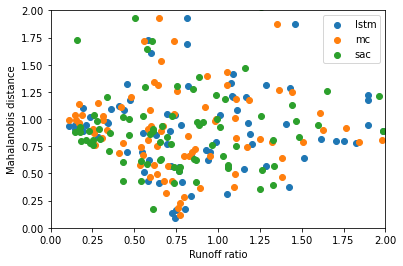

In [20]:
# Plot a distribution, with a point on it, just for an example:
for tsplt in ['time_split1', 'time_split2']:
    for forcing_type in forcing_products:
        spex = get_specifications(tsplt, forcing_type)
        for basin_0str in spex["basin_list"]:
            for model in spex["models"]:
                md = events_results[tsplt][forcing_type][basin_0str][f"MD_{model}"]
                rr = events_results[tsplt][forcing_type][basin_0str][f"RR_{model}"]
                plt.scatter(rr,md, label=model)
                print(f"{model} min {np.min(md)}, mean {np.mean(md)}, max {np.max(md)}")
            plt.xlim([0,2])
            plt.ylim([0,2])
            plt.ylabel("Mahalanobis distance")
            plt.xlabel("Runoff ratio")
            plt.legend()
            plt.show()
            plt.close()
            break
        break
    break

In [21]:
events_results[tsplt][forcing_type][basin_0str].MD_sac

21      1.722288
77      0.426658
127     0.577256
151     1.001467
193     2.029615
          ...   
3508    0.834292
3583    0.902133
3605    0.911457
3620    1.345345
3639    3.994025
Name: MD_sac, Length: 114, dtype: float64

In [22]:
# all_mds = {'time_split1':{'nldas':{},
#                             'daymet':{}}}#,
# #              'time_split2':{'nldas':{},
# #                             'daymet':{}}}
# for tsplt in ['time_split1', 'time_split2']:
#     for forcing_type in forcing_products:
#         spex = get_specifications(tsplt, forcing_type)
#         for basin_0str in spex["basin_list"]:
#             for flow in spex['flows']:
#                 events_results[tsplt][forcing_type][basin_0str].MD_sac

In [23]:
def get_cum_dist_x_y(series):
    x = list(series)
    y = list(range(len(x)))
    for i, _ in enumerate(y):
        y[i] = y[i]/len(y)
    x.sort()
    return x, y

In [24]:
def calculate_rr_location_within_nn_distribution(rr, rr_dist):
    """
        Args:
            rr (float): A runoff ratio for a particular event. 
            rr_dist (series): a sorted series of runoff ratios

    """

    x,y = get_cum_dist_x_y(rr)

    percentile = None
    
    for i, j in zip(x,y):
        if i > rr:
            percentile = y

    return percentile

In [25]:
from sklearn.metrics import r2_score
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [26]:
print("Event based analysis (Note: an event is defined by the magnitude of precipitation, not runoff)")



for tsplt in ['time_split1', 'time_split2']:
    
    spex = get_specifications(tsplt, 'nldas')
        
    rr_nldas_obs = []
    rr_nldas_lstm = []
    rr_nldas_mc = []
    rr_nldas_sac = []
    rr_daymet_obs = []
    rr_daymet_lstm = []
    rr_daymet_mc = []
    rr_daymet_sac = []
    
    if tsplt == 'time_split2':
        rr_nldas_nwm = []
    
    for i, basin_0str in enumerate(spex["basin_list"]):
        
        _nldas = events_results[tsplt]['nldas'][basin_0str]
        nn_nldas = np.min([100, _nldas.shape[0]])
        _daymet = events_results[tsplt]['daymet'][basin_0str]
        nn_daymet = np.min([100, _daymet.shape[0]])
        
        if tsplt == 'time_split2':
            if np.isnan(list(_nldas.RR_nwm.values)).sum() == 0:
                if np.isnan(list(_nldas.RR_obs.values)).sum() == 0:
                    rr_nldas_nwm.extend(list(_nldas.sort_values('MD_obs')['RR_nwm'][:nn_nldas]))                
                    rr_nldas_obs.extend(list(_nldas.sort_values('MD_obs')['RR_obs'][:nn_nldas]))
                    rr_nldas_lstm.extend(list(_nldas.sort_values('MD_obs')['RR_lstm'][:nn_nldas])) 
                    rr_nldas_mc.extend(list(_nldas.sort_values('MD_obs')['RR_mc'][:nn_nldas])) 
                    rr_nldas_sac.extend(list(_nldas.sort_values('MD_obs')['RR_sac'][:nn_nldas])) 
        elif np.isnan(list(_nldas.RR_obs.values)).sum() == 0:
            rr_nldas_obs.extend(list(_nldas.sort_values('MD_obs')['RR_obs'][:nn_nldas]))
            rr_nldas_lstm.extend(list(_nldas.sort_values('MD_obs')['RR_lstm'][:nn_nldas])) 
            rr_nldas_mc.extend(list(_nldas.sort_values('MD_obs')['RR_mc'][:nn_nldas])) 
            rr_nldas_sac.extend(list(_nldas.sort_values('MD_obs')['RR_sac'][:nn_nldas]))
        
        if np.isnan(list(_daymet.RR_obs.values)).sum() ==0:
            rr_daymet_obs.extend(list(_daymet.sort_values('MD_obs')['RR_obs'][:nn_daymet]))
            rr_daymet_lstm.extend(list(_daymet.sort_values('MD_obs')['RR_lstm'][:nn_daymet])) 
            rr_daymet_mc.extend(list(_daymet.sort_values('MD_obs')['RR_mc'][:nn_daymet])) 
            rr_daymet_sac.extend(list(_daymet.sort_values('MD_obs')['RR_sac'][:nn_daymet]))
        
    df = pd.DataFrame(columns=["forcing", "model", "MI", "R2", "n"])
    df.loc[len(df)] = ["NLDAS", "LSTM", 
             np.round(calc_MI(rr_nldas_lstm, rr_nldas_obs, 100),3),
             np.round(r2_score(rr_nldas_lstm, rr_nldas_obs),3),
             len(rr_nldas_obs)]
    df.loc[len(df)] = ["NLDAS", "MC-LSTM", 
             np.round(calc_MI(rr_nldas_mc, rr_nldas_obs, 100),3),
             np.round(r2_score(rr_nldas_mc, rr_nldas_obs),3),
             len(rr_nldas_obs)]
    df.loc[len(df)] = ["NLDAS", "SAC-SMA", 
             np.round(calc_MI(rr_nldas_sac, rr_nldas_obs, 100),3),
             np.round(r2_score(rr_nldas_sac, rr_nldas_obs),3),
             len(rr_nldas_obs)]
    if tsplt == 'time_split2':
        df.loc[len(df)] = ["NLDAS", "NWM", 
             np.round(calc_MI(rr_nldas_nwm, rr_nldas_obs, 100),3),
             np.round(r2_score(rr_nldas_nwm, rr_nldas_obs),3),
             len(rr_nldas_obs)]
    df.loc[len(df)] = ["Daymet", "LSTM", 
             np.round(calc_MI(rr_daymet_lstm, rr_daymet_obs, 100),3),
             np.round(r2_score(rr_daymet_lstm, rr_daymet_obs),3),
             len(rr_daymet_obs)]
    df.loc[len(df)] = ["Daymet", "MC-LSTM", 
             np.round(calc_MI(rr_daymet_mc, rr_daymet_obs, 100),3),
             np.round(r2_score(rr_daymet_mc, rr_daymet_obs),3),
             len(rr_daymet_obs)]
    df.loc[len(df)] = ["Daymet", "SAC-SMA", 
             np.round(calc_MI(rr_daymet_sac, rr_daymet_obs, 100),3),
             np.round(r2_score(rr_daymet_sac, rr_daymet_obs),3),
             len(rr_daymet_obs)]
    print(f"For {tsplt}")
    print("Mutual information between observed and predicted Runoff Ratios")
    print(f"{len(rr_nldas_obs)} total events with NLDAS")
    print("NLDAS LSTM", np.round(calc_MI(rr_nldas_lstm, rr_nldas_obs, 100),3))
    print("NLDAS MC-LSTM", np.round(calc_MI(rr_nldas_mc, rr_nldas_obs, 100),3))
    print("NLDAS Sac-SMA", np.round(calc_MI(rr_nldas_sac, rr_nldas_obs, 100),3))
    if tsplt == 'time_split2':
        print("NLDAS NWM", np.round(calc_MI(rr_nldas_nwm, rr_nldas_obs, 100),3))
    print(f"{len(rr_daymet_obs)} total events with Daymet")
    print("Daymet LSTM", np.round(calc_MI(rr_daymet_lstm, rr_daymet_obs, 100),3))
    print("Daymet MC-LSTM", np.round(calc_MI(rr_daymet_mc, rr_daymet_obs, 100),3))
    print("Daymet Sac-SMA", np.round(calc_MI(rr_daymet_sac, rr_daymet_obs, 100),3))
    print(" ")
    print(df)

Event based analysis (Note: an event is defined by the magnitude of precipitation, not runoff)
For time_split1
Mutual information between observed and predicted Runoff Ratios
42858 total events with NLDAS
NLDAS LSTM 0.165
NLDAS MC-LSTM 0.15
NLDAS Sac-SMA 0.12
52359 total events with Daymet
Daymet LSTM 0.602
Daymet MC-LSTM 0.523
Daymet Sac-SMA 0.439
 
  forcing    model     MI     R2      n
0   NLDAS     LSTM  0.165  0.903  42858
1   NLDAS  MC-LSTM  0.150  0.849  42858
2   NLDAS  SAC-SMA  0.120  0.831  42858
3  Daymet     LSTM  0.602  0.897  52359
4  Daymet  MC-LSTM  0.523  0.866  52359
5  Daymet  SAC-SMA  0.439  0.752  52359
For time_split2
Mutual information between observed and predicted Runoff Ratios
46318 total events with NLDAS
NLDAS LSTM 0.217
NLDAS MC-LSTM 0.206
NLDAS Sac-SMA 0.132
NLDAS NWM 0.198
48421 total events with Daymet
Daymet LSTM 0.677
Daymet MC-LSTM 0.647
Daymet Sac-SMA 0.479
 
  forcing    model     MI     R2      n
0   NLDAS     LSTM  0.217  0.897  46318
1   NLDAS  

In [27]:
# Q - Q plots.

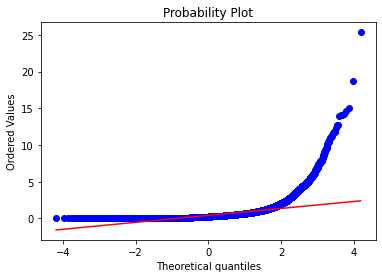

In [28]:
stats.probplot(rr_daymet_obs, dist="norm", plot=pylab)
pylab.show()

In [29]:
import statsmodels.api as sm

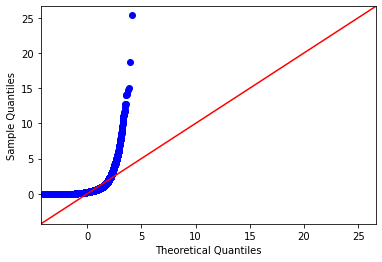

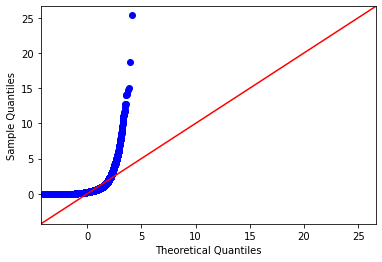

In [31]:
sm.qqplot(np.array(rr_daymet_obs), line ='45')

# Calculate stats for each event on only the 100 closest events

In [38]:
if False:
    with open("event_stats_100_nearest_neibors.pkl", "rb") as fb:
        event_100 = pkl.load(fb)
else:
    event_100 = {'time_split1':{'nldas':{},
                                'daymet':{}},
                 'time_split2':{'nldas':{},
                                'daymet':{}}}

    for tsplt in ['time_split2','time_split1']:
        print(tsplt)

        for forcing_type in forcing_products:
            print(forcing_type)

            spex = get_specifications(tsplt, forcing_type)

            for model in spex['models']:
                print(model)

                event_100[tsplt][forcing_type][model] = {"md_ks":[], "md_mi":[], "md_r2":[], "md_perc":[], 
                                                         "rr_ks":[], "rr_mi":[], "rr_r2":[], "rr_perc":[]}

                for basin_0str in spex["basin_list"]:

                    # Don't include any models if SAC-SMA is NaN
                    if np.isnan(events_results[tsplt][forcing_type][basin_0str][f'MD_sac']).sum() > 0:
                        continue
                    # Don't include any models if Observation is NaN
                    if np.isnan(events_results[tsplt][forcing_type][basin_0str][f'MD_obs']).sum() > 0:
                        continue

                    df = events_results[tsplt][forcing_type][basin_0str]

                    md_obs = df[f'MD_obs']
                    rr_obs = df[f'RR_obs']

                    md_model = df[f'MD_{model}']
                    rr_model = df[f'RR_{model}']

                    for event in df.index.values:

                        this_event_obs_md = md_model[event]
                        this_event_model_md = md_model[event]

                        this_event_obs_rr = rr_obs[event]
                        this_event_model_rr = rr_model[event]

                        # Now find 100 closest events!

                        md_model_100 = md_model.iloc[(df[f'MD_{model}']-this_event_model_md).abs().argsort()[:100]]
                        model_indx = md_model_100.index.values
                        md_obs_100 = md_model.iloc[(df[f'MD_obs']-this_event_model_md).abs().argsort()[:100]]
                        obs_indx = md_model_100.index.values

                        rr_model_100 = df.loc[model_indx, f'RR_{model}']
                        rr_obs_100 = df.loc[obs_indx, f'RR_obs']
                 
                        # For the R2 metric, there needs to be a 1 to 1 correspondence between events
                        # it is not 'simple' the distributions we are interested in,
                        #     but the ability to explain the variance of observation with the model.
                        rr_obs_100_mod = df.loc[model_indx, f'RR_obs']
                        md_obs_100_mod = df.loc[model_indx, f'MD_obs']

                        event_100[tsplt][forcing_type][model]["md_ks"].append(kstest(md_model_100, md_obs_100)[0])
                        event_100[tsplt][forcing_type][model]["md_mi"].append(calc_MI(md_model_100, md_obs_100, 100))

                        event_100[tsplt][forcing_type][model]["rr_ks"].append(kstest(rr_model_100, rr_obs_100)[0])
                        event_100[tsplt][forcing_type][model]["rr_mi"].append(calc_MI(rr_model_100, rr_obs_100, 100))
                 
                        # NOTE: The R2 score needs to have the same events to make a 1 to 1 correspondence.
                        # NOTE: Could do both for the MI and KS as well...
                        event_100[tsplt][forcing_type][model]["md_r2"].append(r2_score(md_model_100, md_obs_100_mod))
                        event_100[tsplt][forcing_type][model]["rr_r2"].append(r2_score(rr_model_100, rr_obs_100_mod))
                        
                        event_100[tsplt][forcing_type][model]["md_perc"].append(stats.percentileofscore(md_model_100,this_event_model_md))
                        event_100[tsplt][forcing_type][model]["rr_perc"].append(stats.percentileofscore(rr_model_100,this_event_model_rr))

    with open("event_stats_100_nearest_neibors.pkl", "wb") as fb:
        pkl.dump(event_100, fb)
        

time_split2
nldas
nwm
lstm
mc
sac
daymet
lstm
mc
sac
time_split1
nldas
lstm
mc
sac
daymet
lstm
mc
sac


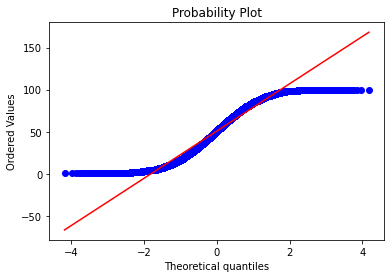

In [178]:

stats.probplot(np.array(np.array(event_100['time_split1']["nldas"]["lstm"]["rr_perc"])), dist="norm", plot=pylab)
pylab.show()

(array([497., 481., 472., 480., 483., 454., 494., 466., 459., 445., 474.,
        459., 474., 472., 458., 462., 489., 454., 463., 435., 488., 474.,
        456., 496., 457., 453., 482., 475., 500., 462., 478., 475., 453.,
        486., 486., 481., 485., 481., 513., 476., 485., 461., 502., 471.,
        491., 488., 489., 483., 508., 408., 522., 482., 482., 480., 492.,
        476., 504., 479., 479., 483., 481., 483., 493., 520., 499., 499.,
        453., 474., 508., 483., 503., 480., 496., 471., 492., 512., 496.,
        473., 471., 463., 507., 488., 494., 467., 458., 484., 465., 488.,
        461., 444., 456., 475., 479., 450., 456., 479., 465., 485., 511.,
        613.]),
 array([  1.  ,   1.99,   2.98,   3.97,   4.96,   5.95,   6.94,   7.93,
          8.92,   9.91,  10.9 ,  11.89,  12.88,  13.87,  14.86,  15.85,
         16.84,  17.83,  18.82,  19.81,  20.8 ,  21.79,  22.78,  23.77,
         24.76,  25.75,  26.74,  27.73,  28.72,  29.71,  30.7 ,  31.69,
         32.68,  33.67,  34.66

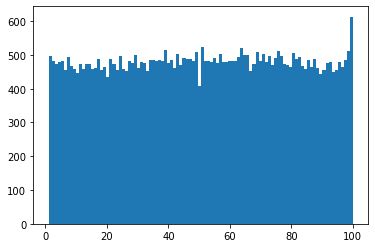

In [180]:
plt.hist(np.array(np.array(event_100['time_split1']["nldas"]["lstm"]["rr_perc"])), bins=100)

In [165]:
def make_q_q(array):
    
    bin_percentage_list = [0]
    bin_quantity_list = [0]
    deviation = [0]
    
    for i, p in enumerate(range(10,110,10)):
        
        total_events = array.shape[0]
        
        a = np.where(array > p-10, 1, 0)
        b = np.where(array <= p, 1, 0)
        
        number_in_bin = np.sum(a*b)

        percent_in_bin = number_in_bin / total_events
        
        deviation.append(percent_in_bin - (1/10))
        
        bin_quantity_list.append(number_in_bin)
        
        percent_in_previous_bin = bin_percentage_list[i]

        bin_percentage_list.append(percent_in_bin + percent_in_previous_bin)
            
    number_in_bins = np.sum(num_rrs)

    return bin_percentage_list, bin_quantity_list, deviation

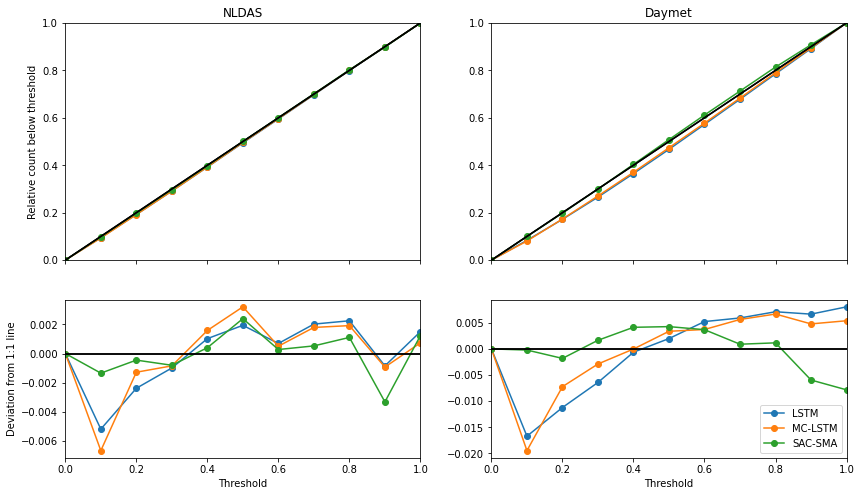

In [174]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=False, figsize=(14,8),gridspec_kw={'height_ratios': [3, 2]})

for model in ["lstm", "mc", "sac"]:

    perc_rrs, num_rrs, deviation = make_q_q(np.array(event_100['time_split1']["nldas"][model]["rr_perc"]))
            
    axs[0,0].plot([i/10 for i in range(11)], perc_rrs, marker="o", label=model)
    axs[1,0].plot([i/10 for i in range(11)], deviation, marker="o")
axs[0,0].set_title("NLDAS")
axs[0,0].set_xlim([0,1])
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel("Relative count below threshold")
axs[1,0].set_ylabel("Deviation from 1:1 line")
axs[0,0].plot([[0,0],[1,1]], "k")
axs[1,0].plot([[0,0],[0,0]], "k")
axs[1,0].set_xlabel("Threshold")
#----------------------------------------------------------------------------
for model in ["lstm", "mc", "sac"]:
    
    perc_rrs, num_rrs, deviation = make_q_q(np.array(event_100['time_split1']["daymet"][model]["rr_perc"]))
    
    axs[0,1].plot([i/10 for i in range(11)], perc_rrs, marker="o", label=model)
    axs[1,1].plot([i/10 for i in range(11)], deviation, marker="o")
axs[0,1].set_title("Daymet")
axs[0,1].set_xlim([0,1])
axs[0,1].set_ylim([0,1])
axs[0,1].plot([[0,0],[1,1]], "k")
axs[1,1].plot([[0,0],[0,0]], "k")
axs[1,1].set_xlabel("Threshold")

plt.legend([spex['labelz'][model] for model in spex['models']])
plt.show()
plt.close()

In [44]:
df_mean = pd.DataFrame(columns=["time_split", "forcing", "model",
                           "RR_MI", "RR_KS", "RR_R2", 
                           "MD_MI", "MD_KS", "MD_R2", "n"])

for tsplt in ['time_split1','time_split2']:
    
    for forcing_type in forcing_products:
        
        spex = get_specifications(tsplt, forcing_type)

        for model in spex['models']:

            df_mean.loc[len(df_mean)] = [tsplt, forcing_type, model, 
                     np.mean(event_100[tsplt][forcing_type][model]["rr_mi"]),
                     np.mean(event_100[tsplt][forcing_type][model]["rr_ks"]),
                     np.mean(event_100[tsplt][forcing_type][model]["rr_r2"]),
                     np.mean(event_100[tsplt][forcing_type][model]["md_mi"]),
                     np.mean(event_100[tsplt][forcing_type][model]["md_ks"]),
                     np.mean(event_100[tsplt][forcing_type][model]["md_r2"]),
                     len(event_100[tsplt][forcing_type][model]["rr_mi"])]

df_mean

,time_split,forcing,model,RR_MI,RR_KS,RR_R2,MD_MI,MD_KS,MD_R2,n
0,time_split1,nldas,lstm,1.579606,0.155480,-0.958795,2.674361,0.024904,0.355197,47968
1,time_split1,nldas,mc,1.504978,0.175463,-0.907809,2.662455,0.029490,0.253308,47968
2,time_split1,nldas,sac,1.462044,0.187870,-2.196576,2.611486,0.031081,-0.197612,47968
3,time_split1,daymet,lstm,2.338575,0.162111,0.307050,2.826301,0.124609,-3.241575,107440
4,time_split1,daymet,mc,2.306547,0.189210,-0.052522,2.843560,0.149331,-3.308699,107440
5,time_split1,daymet,sac,2.265556,0.293772,-2.148050,2.882077,0.190714,-5.185755,107440
6,time_split2,nldas,nwm,1.664006,0.168017,-645.082385,2.625708,0.161808,-9.993412,97145
7,time_split2,nldas,lstm,1.782203,0.180674,0.333151,2.693040,0.125522,-3.517982,97145
8,time_split2,nldas,mc,1.712664,0.178081,0.049451,2.694015,0.144004,-3.455164,97145
9,time_split2,nldas,sac,1.644200,0.212095,-15.141190,2.657217,0.150531,-10.690957,97145


In [46]:
df_median = pd.DataFrame(columns=["time_split", "forcing", "model",
                           "RR_MI", "RR_KS", "RR_R2", 
                           "MD_MI", "MD_KS", "MD_R2", "n"])

for tsplt in ['time_split1','time_split2']:
    
    for forcing_type in forcing_products:
        
        spex = get_specifications(tsplt, forcing_type)

        for model in spex['models']:

            df_median.loc[len(df_median)] = [tsplt, forcing_type, model, 
                     np.round(np.median(event_100[tsplt][forcing_type][model]["rr_mi"]),3),
                     np.round(np.median(event_100[tsplt][forcing_type][model]["rr_ks"]),3),
                     np.round(np.median(event_100[tsplt][forcing_type][model]["rr_r2"]),3),
                     np.round(np.median(event_100[tsplt][forcing_type][model]["md_mi"]),3),
                     np.round(np.median(event_100[tsplt][forcing_type][model]["md_ks"]),3),
                     np.round(np.median(event_100[tsplt][forcing_type][model]["md_r2"]),3),
                     len(event_100[tsplt][forcing_type][model]["rr_mi"])]

df_median

,time_split,forcing,model,RR_MI,RR_KS,RR_R2,MD_MI,MD_KS,MD_R2,n
0,time_split1,nldas,lstm,1.614,0.130,0.826,2.702,0.01,0.735,47968
1,time_split1,nldas,mc,1.545,0.150,0.789,2.691,0.01,0.659,47968
2,time_split1,nldas,sac,1.491,0.154,0.706,2.644,0.01,0.590,47968
3,time_split1,daymet,lstm,2.415,0.140,0.718,2.869,0.11,-0.393,107440
4,time_split1,daymet,mc,2.376,0.160,0.640,2.890,0.14,-0.793,107440
5,time_split1,daymet,sac,2.342,0.280,0.342,2.955,0.19,-2.009,107440
6,time_split2,nldas,nwm,1.653,0.130,0.647,2.681,0.15,-1.705,97145
7,time_split2,nldas,lstm,1.754,0.140,0.755,2.757,0.11,-0.492,97145
8,time_split2,nldas,mc,1.692,0.140,0.711,2.758,0.13,-0.658,97145
9,time_split2,nldas,sac,1.607,0.170,0.558,2.726,0.14,-1.516,97145


In [47]:
if False:
    with open("event_stats_100_rr1_nearest_neibors.pkl", "rb") as fb:
        event_100_rr1 = pkl.load(fb)
else:
    event_100_rr1 = {'time_split1':{'nldas':{},
                                'daymet':{}},
                 'time_split2':{'nldas':{},
                                'daymet':{}}}

    for tsplt in ['time_split2','time_split1']:
        print(tsplt)

        for forcing_type in forcing_products:
            print(forcing_type)

            spex = get_specifications(tsplt, forcing_type)

            for model in spex['models']:
                print(model)

                event_100_rr1[tsplt][forcing_type][model] = {"md_ks":[], "md_mi":[], "md_r2":[], 
                                                         "rr_ks":[], "rr_mi":[], "rr_r2":[]}

                for basin_0str in spex["basin_list"]:

                    # Don't include any models if SAC-SMA is NaN
                    if np.isnan(events_results[tsplt][forcing_type][basin_0str][f'MD_sac']).sum() > 0:
                        continue
                    # Don't include any models if Observation is NaN
                    if np.isnan(events_results[tsplt][forcing_type][basin_0str][f'MD_obs']).sum() > 0:
                        continue

                    df = events_results[tsplt][forcing_type][basin_0str]

                    md_obs = df[f'MD_{model}']

                    md_model = df[f'MD_{model}']

                    for event in df.index.values:

                        this_event_obs_md = md_model[event]
                        this_event_model_md = md_model[event]
                        
                        ###################################################
                        ###################################################
                        # Now lets consider events with runoff ratios of 1 or less!
                        if df.loc[event, f'RR_obs'] > 1:
                            continue

                        # Now find 100 closest events!

                        md_model_100 = md_model.iloc[(df[f'MD_{model}']-this_event_model_md).abs().argsort()[:100]]
                        model_indx = md_model_100.index.values
                        md_obs_100 = md_model.iloc[(df[f'MD_obs']-this_event_model_md).abs().argsort()[:100]]
                        obs_indx = md_model_100.index.values

                        rr_model_100 = df.loc[model_indx, f'RR_{model}']
                        rr_obs_100 = df.loc[obs_indx, f'RR_obs']
                 
                        # For the R2 metric, there needs to be a 1 to 1 correspondence between events
                        # it is not 'simple' the distributions we are interested in,
                        #     but the ability to explain the variance of observation with the model.
                        rr_obs_100_mod = df.loc[model_indx, f'RR_obs']
                        md_obs_100_mod = df.loc[model_indx, f'MD_obs']

                        event_100_rr1[tsplt][forcing_type][model]["md_ks"].append(kstest(md_model_100, md_obs_100)[0])
                        event_100_rr1[tsplt][forcing_type][model]["md_mi"].append(calc_MI(md_model_100, md_obs_100, 100))

                        event_100_rr1[tsplt][forcing_type][model]["rr_ks"].append(kstest(rr_model_100, rr_obs_100)[0])
                        event_100_rr1[tsplt][forcing_type][model]["rr_mi"].append(calc_MI(rr_model_100, rr_obs_100, 100))
                 
                        # NOTE: The R2 score needs to have the same events to make a 1 to 1 correspondence.
                        # NOTE: Could do both for the MI and KS as well...
                        event_100_rr1[tsplt][forcing_type][model]["md_r2"].append(r2_score(md_model_100, md_obs_100_mod))
                        event_100_rr1[tsplt][forcing_type][model]["rr_r2"].append(r2_score(rr_model_100, rr_obs_100_mod))

    with open("event_stats_100_rr1_nearest_neibors.pkl", "wb") as fb:
        pkl.dump(event_100_rr1, fb)
        

time_split2
nldas
nwm
lstm
mc
sac
daymet
lstm
mc
sac
time_split1
nldas
lstm
mc
sac
daymet
lstm
mc
sac


In [48]:
df_median = pd.DataFrame(columns=["time_split", "forcing", "model",
                           "RR_MI", "RR_KS", "RR_R2", 
                           "MD_MI", "MD_KS", "MD_R2", "n"])

for tsplt in ['time_split1','time_split2']:
    
    for forcing_type in forcing_products:
        
        spex = get_specifications(tsplt, forcing_type)

        for model in spex['models']:

            df_median.loc[len(df_median)] = [tsplt, forcing_type, model, 
                     np.round(np.median(event_100_rr1[tsplt][forcing_type][model]["rr_mi"]),3),
                     np.round(np.median(event_100_rr1[tsplt][forcing_type][model]["rr_ks"]),3),
                     np.round(np.median(event_100_rr1[tsplt][forcing_type][model]["rr_r2"]),3),
                     np.round(np.median(event_100_rr1[tsplt][forcing_type][model]["md_mi"]),3),
                     np.round(np.median(event_100_rr1[tsplt][forcing_type][model]["md_ks"]),3),
                     np.round(np.median(event_100_rr1[tsplt][forcing_type][model]["md_r2"]),3),
                     len(event_100_rr1[tsplt][forcing_type][model]["rr_mi"])]

df_median

,time_split,forcing,model,RR_MI,RR_KS,RR_R2,MD_MI,MD_KS,MD_R2,n
0,time_split1,nldas,lstm,1.586,0.140,0.802,2.730,0.01,0.697,35407
1,time_split1,nldas,mc,1.495,0.160,0.758,2.706,0.02,0.604,35407
2,time_split1,nldas,sac,1.456,0.165,0.683,2.651,0.02,0.540,35407
3,time_split1,daymet,lstm,2.410,0.148,0.685,2.880,0.11,-0.505,91162
4,time_split1,daymet,mc,2.373,0.163,0.611,2.901,0.15,-0.923,91162
5,time_split1,daymet,sac,2.340,0.290,0.265,2.966,0.19,-2.163,91162
6,time_split2,nldas,nwm,1.635,0.140,0.606,2.681,0.15,-1.939,72339
7,time_split2,nldas,lstm,1.754,0.160,0.701,2.768,0.12,-0.599,72339
8,time_split2,nldas,mc,1.689,0.160,0.656,2.761,0.14,-0.789,72339
9,time_split2,nldas,sac,1.596,0.180,0.506,2.736,0.14,-1.750,72339


# Try to recreate some plots from Beven 2019: 
Towards a methodology for testing models as hypotheses in the inexact sciences

In [28]:
def plot_runoff_ratio_distribution(tsplt, basin_0str, _nldas, _daymet):
    
    obs_nldas = _nldas.sort_values(f"MD_obs")[:100]
    x,y = get_cum_dist_x_y(obs_nldas['RR_obs'].values)
    plt.plot(x,y, label="NLDAS Observed", c='k')
    max_obs_nldas = np.max(x)
    
    lstm_nldas = _nldas.sort_values(f"MD_lstm")[:100]
    x,y = get_cum_dist_x_y(lstm_nldas['RR_lstm'].values)
    plt.plot(x,y, label="NLDAS lstm", c=colz[0])
    
    mc_nldas = _nldas.sort_values(f"MD_mc")[:100]
    x,y = get_cum_dist_x_y(mc_nldas['RR_mc'].values)
    plt.plot(x,y, label="NLDAS mc-lstm", c=colz[1])
    
    sac_nldas = _nldas.sort_values(f"MD_sac")[:100]
    x,y = get_cum_dist_x_y(sac_nldas['RR_sac'].values)
    plt.plot(x,y, label="NLDAS sac-sma", c=colz[2])
    
    if tsplt == "time_split2":
        nwm_nldas = _nldas.sort_values(f"MD_nwm")[:100]
        x,y = get_cum_dist_x_y(nwm_nldas['RR_nwm'].values)
        plt.plot(x,y, label="NLDAS NWM", c=colz[3])

    obs_daymet = _daymet.sort_values(f"MD_obs")[:100]
    x,y = get_cum_dist_x_y(obs_daymet['RR_obs'].values)
    plt.plot(x,y,'--',label="Daymet Observed", c='k')
    max_obs_daymet = np.max(x)
    
    lstm_daymet = _daymet.sort_values(f"MD_lstm")[:100]
    x,y = get_cum_dist_x_y(lstm_daymet['RR_lstm'].values)
    plt.plot(x,y,'--',label="Daymet lstm", c=colz[0])
    
    mc_daymet = _daymet.sort_values(f"MD_mc")[:100]
    x,y = get_cum_dist_x_y(mc_daymet['RR_mc'].values)
    plt.plot(x,y,'--',label="Daymet mc-lstm", c=colz[1])
    
    sac_daymet = _daymet.sort_values(f"MD_sac")[:100]
    x,y = get_cum_dist_x_y(sac_daymet['RR_sac'].values)
    plt.plot(x,y,'--',label="Daymet sac-sma", c=colz[2])

    plt.title(basin_0str)
    plt.ylabel("non-exceedance probability, P(x ≤ x*)")
    plt.xlabel("Runoff Ratio")
    max_observed = np.max(np.array([max_obs_nldas, max_obs_daymet]))
    plt.xlim([0,max_observed])
    plt.show()
    plt.close()

In [50]:
def plot_basin_scatter_and_distribution_from_md(tsplt, basin_0str, _nldas, _daymet, rr_bound=1):
    
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(1, 4, 1)
    
    obs_nldas = _nldas.sort_values(f"MD_obs")[:100]
    x,y = get_cum_dist_x_y(obs_nldas['RR_obs'].values)
    ax1.plot(x,y, label="NLDAS Observed", c='k')
    max_obs_nldas = np.max(x)
    
    lstm_nldas = _nldas.sort_values(f"MD_lstm")[:100]
    x,y = get_cum_dist_x_y(lstm_nldas['RR_lstm'].values)
    ax1.plot(x,y, label="NLDAS lstm", c=colz[0])
    
    mc_nldas = _nldas.sort_values(f"MD_mc")[:100]
    x,y = get_cum_dist_x_y(mc_nldas['RR_mc'].values)
    ax1.plot(x,y, label="NLDAS mc-lstm", c=colz[1])
    
    sac_nldas = _nldas.sort_values(f"MD_sac")[:100]
    x,y = get_cum_dist_x_y(sac_nldas['RR_sac'].values)
    ax1.plot(x,y, label="NLDAS sac-sma", c=colz[2])
    
    if tsplt == "time_split2":
        nwm_nldas = _nldas.sort_values(f"MD_nwm")[:100]
        x,y = get_cum_dist_x_y(nwm_nldas['RR_nwm'].values)
        ax1.plot(x,y, label="NLDAS NWM", c=colz[3])

    obs_daymet = _daymet.sort_values(f"MD_obs")[:100]
    x,y = get_cum_dist_x_y(obs_daymet['RR_obs'].values)
    ax1.plot(x,y,'--',label="Daymet Observed", c='k')
    max_obs_daymet = np.max(x)
    
    lstm_daymet = _daymet.sort_values(f"MD_lstm")[:100]
    x,y = get_cum_dist_x_y(lstm_daymet['RR_lstm'].values)
    ax1.plot(x,y,'--',label="Daymet lstm", c=colz[0])
    
    mc_daymet = _daymet.sort_values(f"MD_mc")[:100]
    x,y = get_cum_dist_x_y(mc_daymet['RR_mc'].values)
    ax1.plot(x,y,'--',label="Daymet mc-lstm", c=colz[1])
    
    sac_daymet = _daymet.sort_values(f"MD_sac")[:100]
    x,y = get_cum_dist_x_y(sac_daymet['RR_sac'].values)
    ax1.plot(x,y,'--',label="Daymet sac-sma", c=colz[2])

    ax1.set_title(basin_0str)
    ax1.set_ylabel("non-exceedance probability, P(x ≤ x*)")
    ax1.set_xlabel("Runoff Ratio")
    max_observed = np.max(np.array([max_obs_nldas, max_obs_daymet]))
    ax1.set_xlim([0,rr_bound])
    
#---------------------------------------------------------------------------------------------------------#
    ax2 = fig.add_subplot(1, 4, 2)
    ax2.scatter(obs_nldas['RR_obs'],obs_nldas['MD_obs'], marker="o", label="NLDAS Observed", c='k')
    ax2.scatter(lstm_nldas['RR_lstm'],lstm_nldas['MD_lstm'], marker="o", label="NLDAS lstm", c=colz[0])
    ax2.scatter(mc_nldas['RR_mc'],mc_nldas['MD_mc'], marker="o", label="NLDAS mc-lstm", c=colz[1])
    ax2.scatter(sac_nldas['RR_sac'], sac_nldas['MD_sac'],marker="o", label="NLDAS sac-sma", c=colz[2])
    if tsplt == "time_split2":
        ax2.scatter(nwm_nldas['RR_nwm'],nwm_nldas['MD_nwm'], marker="o", label="NLDAS NWM", c=colz[3])
        
    ax2.scatter(obs_daymet['RR_obs'],obs_daymet['MD_obs'], marker="*", label="Daymet Observed", c='k')
    ax2.scatter(lstm_daymet['RR_lstm'],lstm_daymet['MD_lstm'], marker="*", label="Daymet lstm", c=colz[0])
    ax2.scatter(mc_daymet['RR_mc'],mc_daymet['MD_mc'], marker="*", label="Daymet mc-lstm", c=colz[1])
    ax2.scatter(sac_daymet['RR_sac'],sac_daymet['MD_sac'], marker="*", label="Daymet sac-sma", c=colz[2])  
    ax2.set_ylabel("Mahalanobis distance")
    ax2.set_xlabel("Runoff coefficient")
    ax2.set_xlim([0,rr_bound])

#---------------------------------------------------------------------------------------------------------#    
    ax3 = fig.add_subplot(1, 4, 3)
    ax3.scatter(obs_nldas['RR_obs'], obs_nldas['IN_obs'], marker="o", label="NLDAS Observed", c='k')
    ax3.scatter(lstm_nldas['RR_lstm'], lstm_nldas['IN_lstm'], marker="o", label="NLDAS lstm", c=colz[0])
    ax3.scatter(mc_nldas['RR_mc'], mc_nldas['IN_mc'], marker="o", label="NLDAS mc-lstm", c=colz[1])
    ax3.scatter(sac_nldas['RR_sac'], sac_nldas['IN_sac'], marker="o", label="NLDAS sac-sma", c=colz[2])
    if tsplt == "time_split2":
        ax3.scatter(nwm_nldas['RR_nwm'], nwm_nldas['IN_nwm'], marker="o", label="NLDAS NWM", c=colz[3])
        
    ax3.scatter(obs_daymet['RR_obs'], obs_daymet['IN_obs'], marker="*", label="Daymet Observed", c='k')
    ax3.scatter(lstm_daymet['RR_lstm'], lstm_daymet['IN_lstm'], marker="*", label="Daymet lstm", c=colz[0])
    ax3.scatter(mc_daymet['RR_mc'], mc_daymet['IN_mc'], marker="*", label="Daymet mc-lstm", c=colz[1])
    ax3.scatter(sac_daymet['RR_sac'], sac_daymet['IN_sac'], marker="*", label="Daymet sac-sma", c=colz[2])  
    ax3.set_ylabel("Initial flow")
    ax3.set_xlabel("Runoff coefficient")
    ax3.set_xlim([0,rr_bound])

#---------------------------------------------------------------------------------------------------------#    
    ax4 = fig.add_subplot(1, 4, 4)
    ax4.scatter(obs_nldas['RR_obs'], obs_nldas['total_precip'], marker="o", label="NLDAS Observed", c='k')
    ax4.scatter(lstm_nldas['RR_lstm'], lstm_nldas['total_precip'], marker="o", label="NLDAS lstm", c=colz[0])
    ax4.scatter(mc_nldas['RR_mc'], mc_nldas['total_precip'], marker="o", label="NLDAS mc-lstm", c=colz[1])
    ax4.scatter(sac_nldas['RR_sac'], sac_nldas['total_precip'], marker="o", label="NLDAS sac-sma", c=colz[2])
    if tsplt == "time_split2":
        ax4.scatter(nwm_nldas['RR_nwm'], nwm_nldas['total_precip'], marker="o", label="NLDAS NWM", c=colz[3])
        
    ax4.scatter(obs_daymet['RR_obs'], obs_daymet['total_precip'], marker="*", label="Daymet Observed", c='k')
    ax4.scatter(lstm_daymet['RR_lstm'], lstm_daymet['total_precip'], marker="*", label="Daymet lstm", c=colz[0])
    ax4.scatter(mc_daymet['RR_mc'], mc_daymet['total_precip'], marker="*", label="Daymet mc-lstm", c=colz[1])
    ax4.scatter(sac_daymet['RR_sac'], sac_daymet['total_precip'], marker="*", label="Daymet sac-sma", c=colz[2])  
    ax4.set_ylabel("Event rainfall total")
    ax4.set_xlabel("Runoff coefficient")
    ax4.set_xlim([0,rr_bound])

    
#---------------------------------------------------------------------------------------------------------#
    plt.legend()
    plt.show()
    plt.close()

LSTM absolute mass error 0.36 0.21
MC-LSTM absolute mass error 0.37 0.29
SacSMA absolute mass error 0.46 0.57


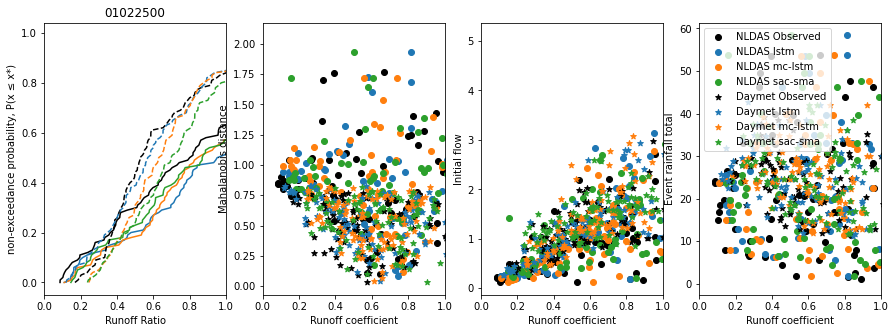

LSTM absolute mass error 0.24 0.22
MC-LSTM absolute mass error 0.28 0.25
SacSMA absolute mass error 0.4 0.64


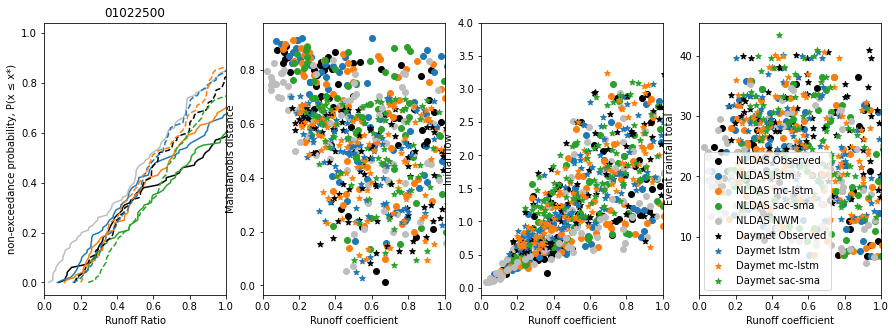

LSTM absolute mass error 0.27 0.2
MC-LSTM absolute mass error 0.4 0.21
SacSMA absolute mass error 0.38 0.24


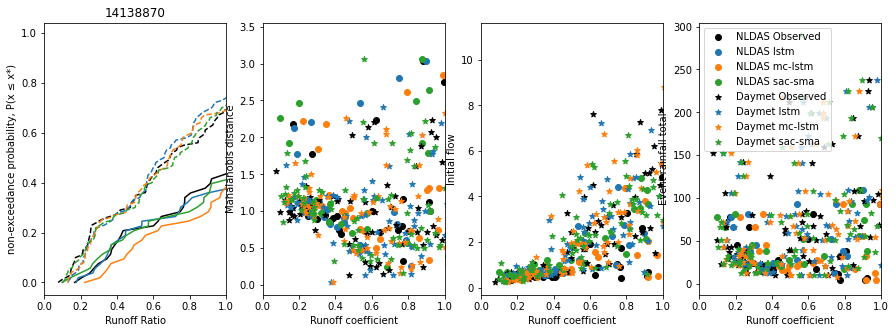

LSTM absolute mass error 0.39 0.3
MC-LSTM absolute mass error 0.58 0.3
SacSMA absolute mass error 0.5 0.37


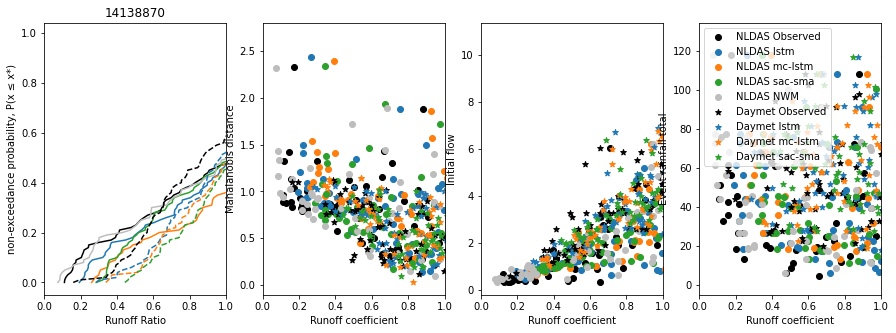

LSTM absolute mass error 0.56 0.31
MC-LSTM absolute mass error 0.61 0.25
SacSMA absolute mass error 0.36 1.21


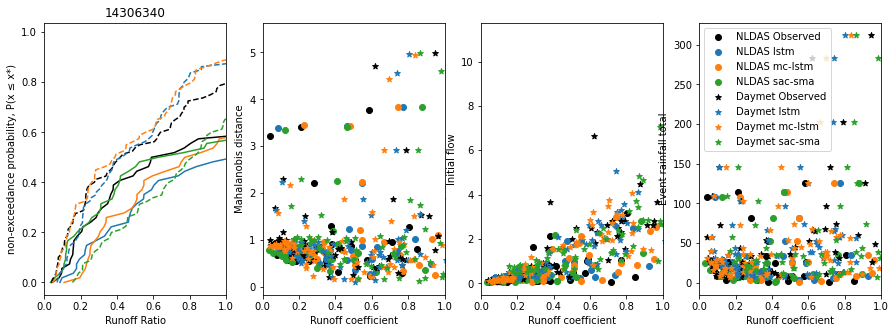

LSTM absolute mass error 0.41 0.73
MC-LSTM absolute mass error 0.46 0.69
SacSMA absolute mass error 0.56 0.68


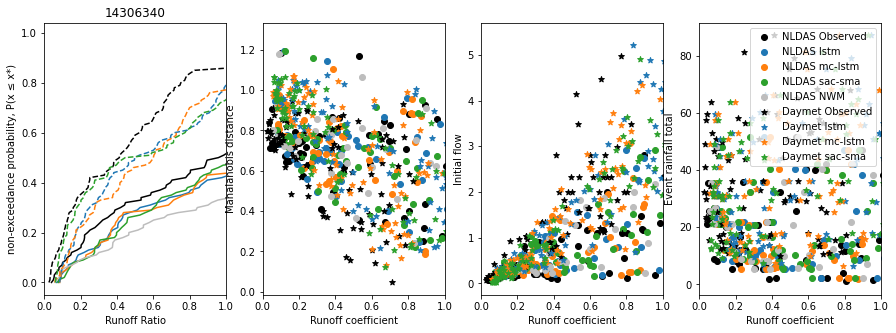

LSTM absolute mass error 0.13 0.22
MC-LSTM absolute mass error 0.18 0.24
SacSMA absolute mass error 0.22 0.48


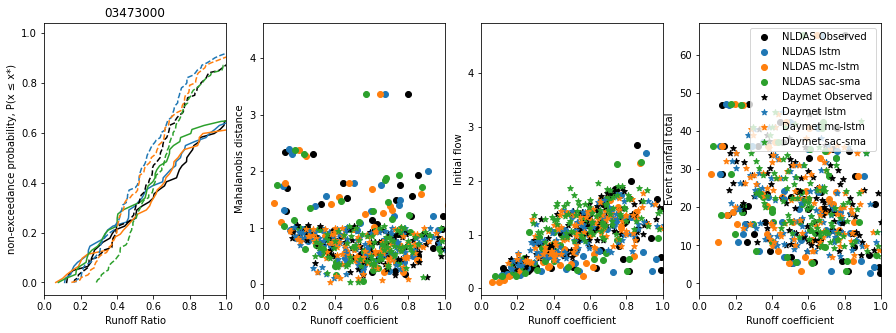

LSTM absolute mass error 0.19 0.38
MC-LSTM absolute mass error 0.23 0.32
SacSMA absolute mass error 0.27 0.43


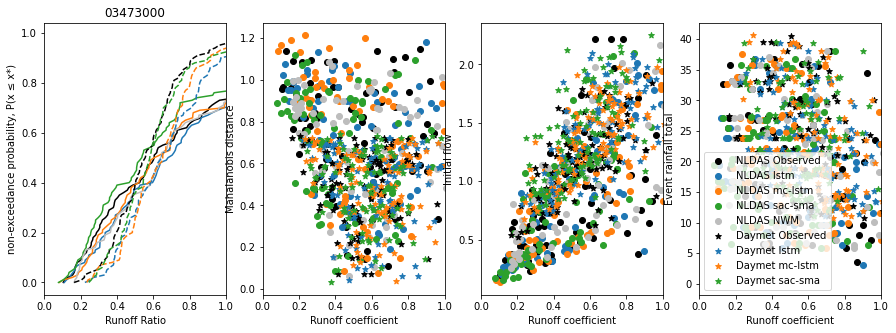

LSTM absolute mass error 203.45 41.02
MC-LSTM absolute mass error 286.99 43.18
SacSMA absolute mass error 227.86 180.48


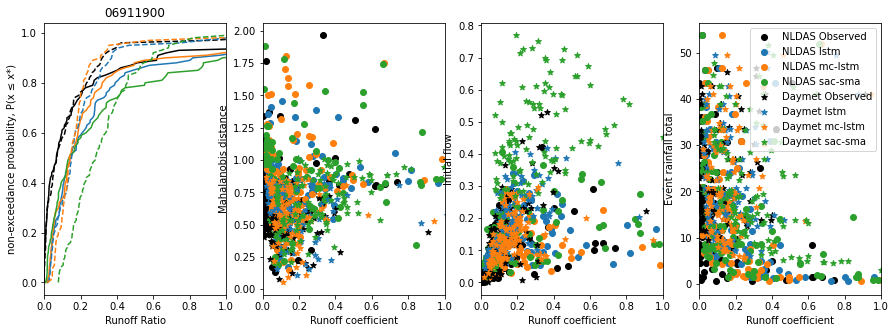

LSTM absolute mass error 41.07 27.88
MC-LSTM absolute mass error 24.96 64.77
SacSMA absolute mass error 77.68 29.53


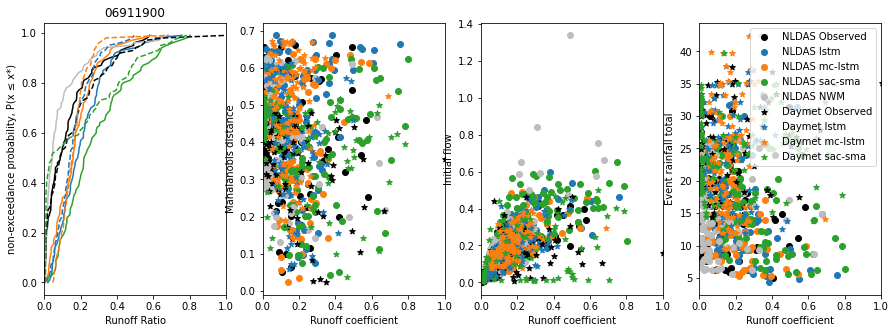

LSTM absolute mass error 0.2 0.16
MC-LSTM absolute mass error 0.17 0.16
SacSMA absolute mass error 0.2 0.21


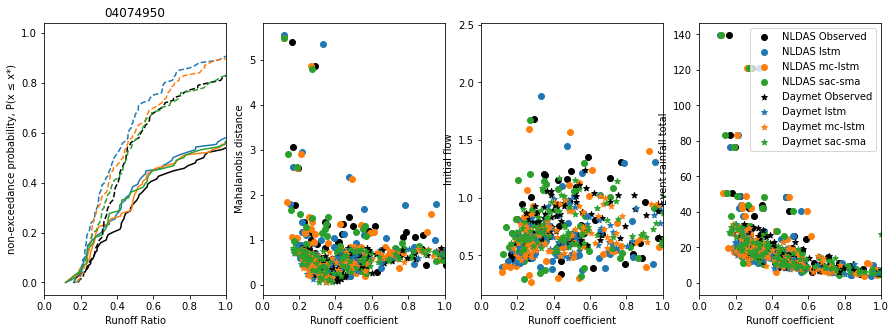

LSTM absolute mass error 0.22 0.2
MC-LSTM absolute mass error 0.2 0.19
SacSMA absolute mass error 0.22 0.29


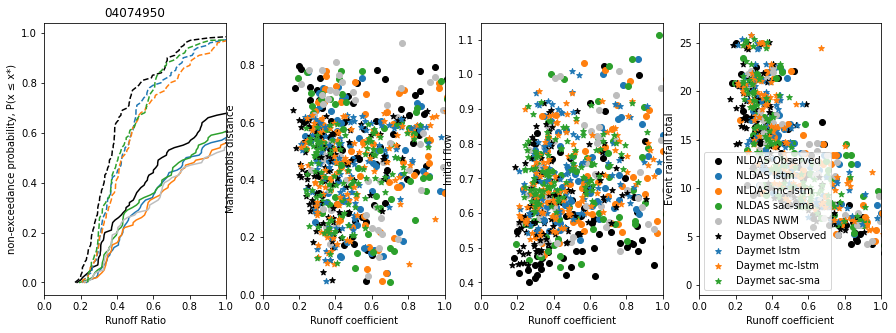

LSTM absolute mass error 0.35 0.57
MC-LSTM absolute mass error 0.49 0.82
SacSMA absolute mass error 0.57 2.71


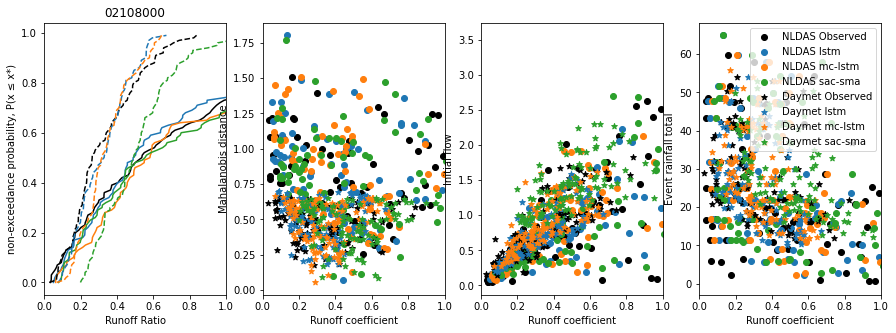

LSTM absolute mass error 0.52 0.69
MC-LSTM absolute mass error 0.43 0.77
SacSMA absolute mass error 0.85 3.72


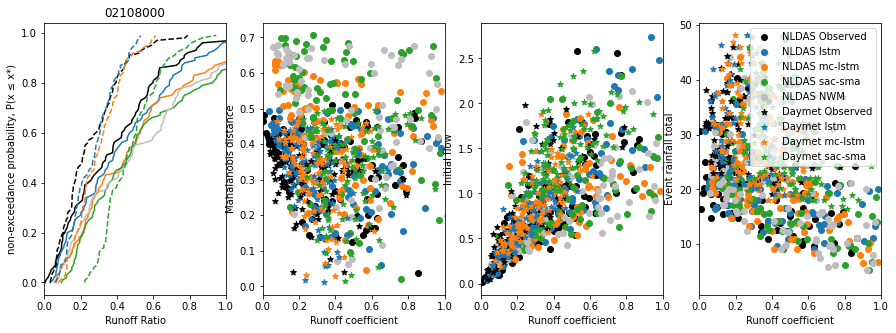

LSTM absolute mass error 0.17 0.23
MC-LSTM absolute mass error 0.29 0.28
SacSMA absolute mass error 0.28 0.41


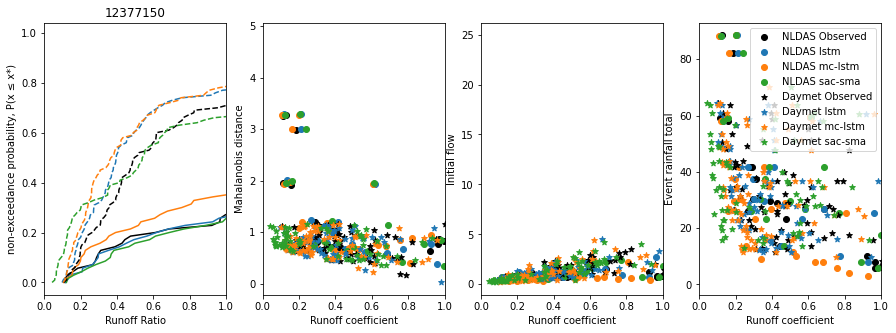

LSTM absolute mass error 0.18 0.26
MC-LSTM absolute mass error 0.32 0.27
SacSMA absolute mass error 0.32 0.46


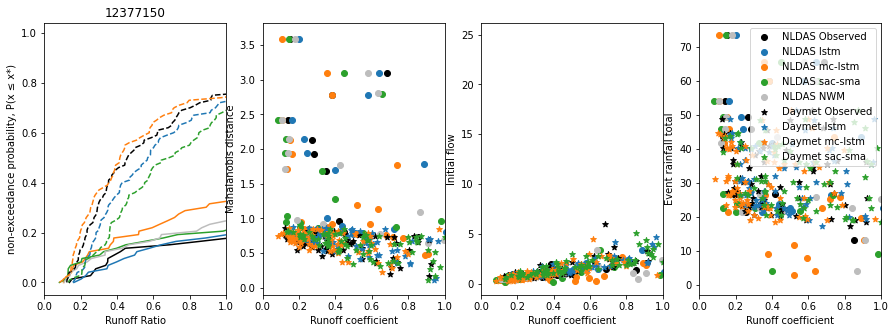

LSTM absolute mass error 8.66 2.3
MC-LSTM absolute mass error 10.25 2.31
SacSMA absolute mass error 25.35 20.59


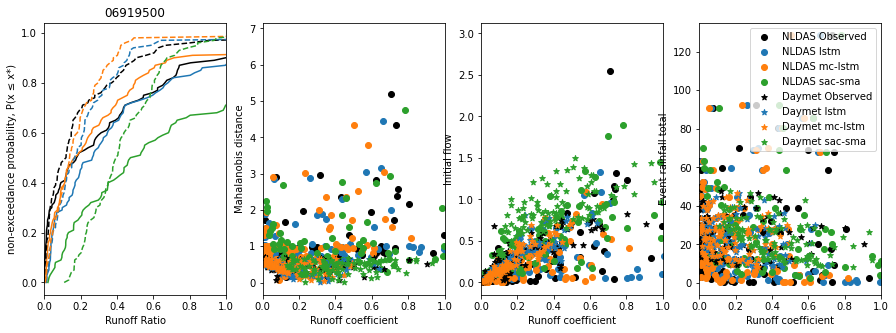

LSTM absolute mass error 475.34 103.65
MC-LSTM absolute mass error 414.51 221.44
SacSMA absolute mass error 88.57 386.9


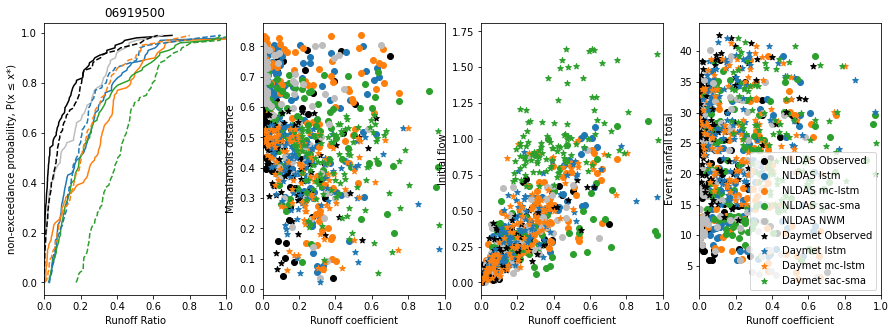

LSTM absolute mass error 11.4 15.84
MC-LSTM absolute mass error 8.87 13.52
SacSMA absolute mass error 12.18 9.87


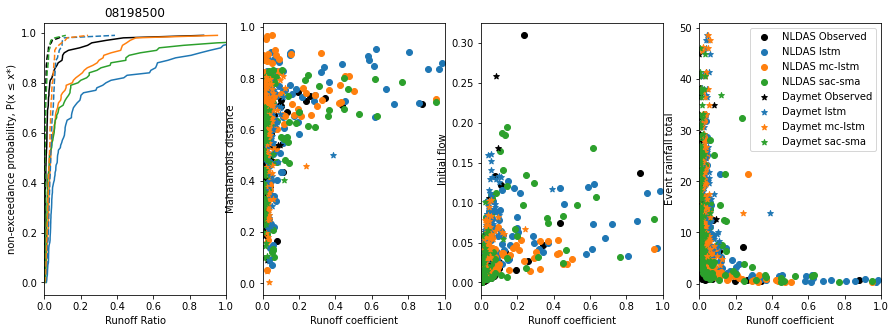

LSTM absolute mass error 13.33 12.69
MC-LSTM absolute mass error 15.86 10.79
SacSMA absolute mass error 11.06 45.32


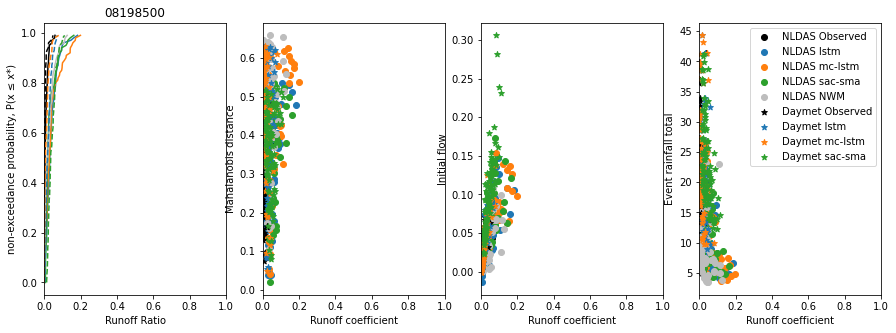

In [51]:
for i in [int(530 * np.random.rand()) for j in range(10)]:

    for tsplt in ['time_split1', 'time_split2']:
        
        spex = get_specifications(tsplt, 'nldas')
        
        basin_0str = spex["basin_list"][i]

        _nldas = events_results[tsplt]['nldas'][basin_0str]
        _daymet = events_results[tsplt]['daymet'][basin_0str]

        print("LSTM absolute mass error", np.round(np.mean(_nldas.loc[:,'AME_lstm']),2), 
                                          np.round(np.mean(_daymet.loc[:,'AME_lstm']),2))
        print("MC-LSTM absolute mass error", np.round(np.mean(_nldas.loc[:,'AME_mc']),2),
                                             np.round(np.mean(_daymet.loc[:,'AME_mc']),2))
        print("SacSMA absolute mass error", np.round(np.mean(_nldas.loc[:,'AME_sac']),2),
                                            np.round(np.mean(_daymet.loc[:,'AME_sac']),2))

#        scatter_plot_of_rr_events_for_basin(_nldas, _daymet, basin_0str, spex, plot_bounds=[0,2])
        plot_basin_scatter_and_distribution_from_md(tsplt, basin_0str, _nldas, _daymet)

In [49]:
def plot_event_hydrograph(event, basin_0str,
                              flow_mm_nldas, flow_mm_daymet, 
                              forcing_nldas, forcing_daymet):
        
    print(event)
    sevd = event[0]# StartEventDate
    eevd = event[1]-1# EndEventDate

    flow_obs_nldas = np.array(flow_mm_nldas['obs'].iloc[sevd:eevd])
    flow_obs_daymet = np.array(flow_mm_daymet['obs'].iloc[sevd:eevd])
    flow_lstm_nldas = np.array(flow_mm_nldas['lstm'].iloc[sevd:eevd])
    flow_lstm_daymet = np.array(flow_mm_daymet['lstm'].iloc[sevd:eevd])
    flow_mc_nldas = np.array(flow_mm_nldas['mc'].iloc[sevd:eevd])
    flow_mc_daymet = np.array(flow_mm_daymet['mc'].iloc[sevd:eevd])
    flow_sac_nldas = np.array(flow_mm_nldas['sac'].iloc[sevd:eevd])
    flow_sac_daymet = np.array(flow_mm_daymet['sac'].iloc[sevd:eevd])    
    precip_nldas = forcing_nldas[precip_column_map['nldas']].values[sevd:eevd]
    precip_daymet = forcing_daymet[precip_column_map['daymet']].values[sevd:eevd]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(flow_obs_nldas, label="Observed runoff", c="k")

    ax1.plot(flow_lstm_nldas, label="lstm nldas", c=colz[0])
    ax1.plot(flow_lstm_daymet, '--', label="lstm daymet", c=colz[0])
    ax1.plot(flow_mc_nldas, label="MC-LSTM nldas", c=colz[1])
    ax1.plot(flow_mc_daymet, '--', label="MC-LSTM daymet", c=colz[1])
    ax1.plot(flow_sac_nldas, label="SAC-SMA nldas", c=colz[2])
    ax1.plot(flow_sac_daymet, '--', label="SAC-SMA daymet", c=colz[2])
    ax2.plot(precip_nldas, label="precip nldas", c='r')
    ax2.plot(precip_daymet, '--', label="precip daymet", c='r')
    ax1.set_ylabel("Runoff [mm/day]")
    ax2.set_ylabel("Precip [mm/day]")
    ax1.legend(loc='center left', bbox_to_anchor=(-0.5, .3))
    ax2.legend(loc='center left', bbox_to_anchor=(1.1, .3))

    ts = pd.to_datetime(str(flow_mm_nldas['obs'].index[event[0]])) 
    d = ts.strftime('%Y.%m.%d')
    
    plt.title(f"{basin_0str}, {d}")
    
    plt.show()
    plt.close()

def plot_event_scatter(events_results, spex, basin_0str):
    
    for model in spex["models"]:
        
        basin_data = events_results[spex['tsplt']][spex['forcing_type']][basin_0str]
        basin_data = basin_data.sort_values(f"MD_{model}")[:100]
        md = basin_data[f"MD_{model}"]
        rr = basin_data[f"RR_{model}"]
        plt.scatter(rr,md, label=model)

    basin_data = events_results[spex['tsplt']][spex['forcing_type']][basin_0str]
    basin_data = basin_data.sort_values("MD_obs")[:100]
    md = basin_data["MD_obs"]
    rr = basin_data["RR_obs"]
    plt.scatter(rr,md, label="obs", c="k")
        
    plt.ylabel("Mahalanobis distance")
    plt.xlabel("Runoff ratio")
    plt.legend()
    plt.show()
    plt.close()
    
def plot_runoff_coefficient_distribution(events_results, spex, basin_0str):
    for model in spex["models"]:
        
        basin_data = events_results[spex['tsplt']][spex['forcing_type']][basin_0str]
        basin_data = basin_data.sort_values(f"MD_{model}")[:100]
        rr = basin_data[f"RR_{model}"]
        x,y = get_cum_dist_x_y(rr.values)
        plt.plot(x,y, label=model)
        
    basin_data = events_results[spex['tsplt']][spex['forcing_type']][basin_0str]
    basin_data = basin_data.sort_values("MD_obs")[:100]
    rr = basin_data["RR_obs"]
    x,y = get_cum_dist_x_y(rr.values)
    plt.plot(x,y, label="obs", c='k')
        
    plt.ylabel("Number of events")
    plt.xlabel("Runoff ratio")
    plt.legend()
    plt.show()
    plt.close()


Number of precipitation events 123 above threshold 0.34mm and a window below 0.04mm
Number of precipitation events 197 above threshold 3.24mm and a window below 0.22mm


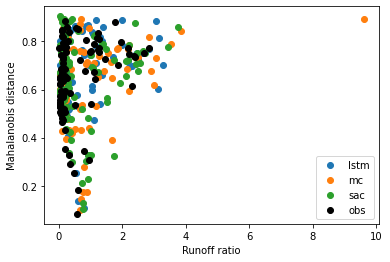

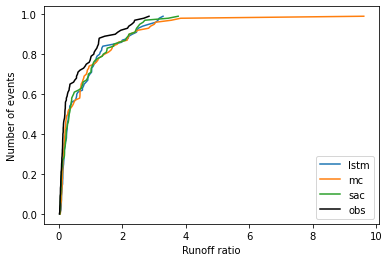

[348, 355]


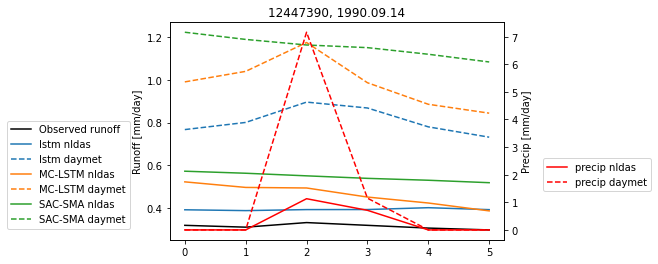

Number of precipitation events 104 above threshold 0.15mm and a window below 0.01mm
Number of precipitation events 253 above threshold 2.31mm and a window below 0.22mm


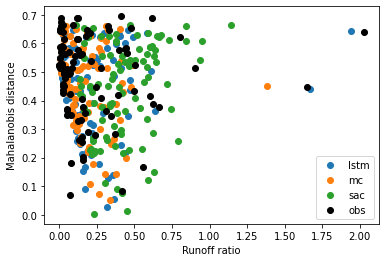

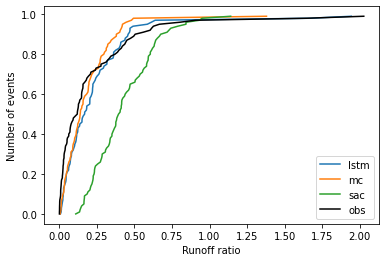

[370, 379]


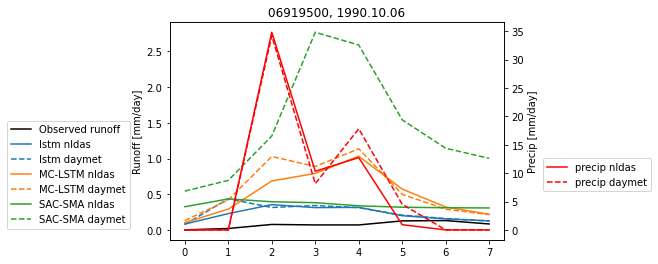

Number of precipitation events 141 above threshold 0.26mm and a window below 0.02mm
Number of precipitation events 282 above threshold 5.45mm and a window below 1.28mm


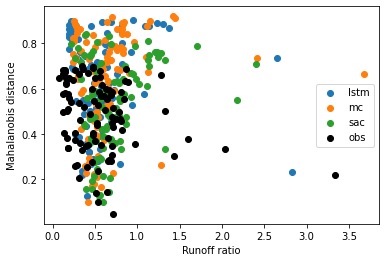

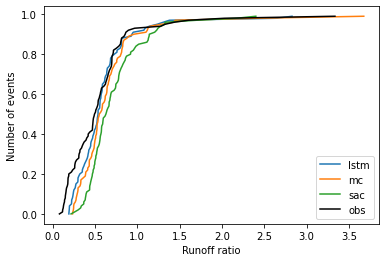

[1210, 1216]


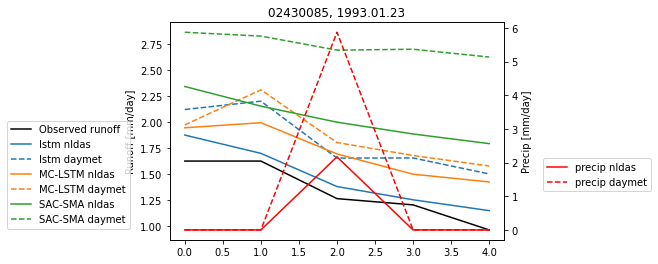

In [50]:
tsplt ='time_split1'

overlapping_events = {basin:[] for basin in spex["basin_list"]}
        
spex = get_specifications(tsplt, 'nldas')
start_date = spex['start_date']
end_date = spex['end_date']
    
    
for random_basin in [int(530 * np.random.rand()) for j in range(3)]:
    
    basin_0str = spex["basin_list"][random_basin]
        
    spex = get_specifications(tsplt, 'nldas')
    forcing_nldas, precip_events_nldas = load_forcing_and_identify_events(tsplt, 
                                                              basin_0str, 
                                                              file_name_map, 
                                                              'nldas')

    spex = get_specifications(tsplt, 'daymet')
    forcing_daymet, precip_events_daymet = load_forcing_and_identify_events(tsplt, 
                                                              basin_0str, 
                                                              file_name_map, 
                                                              'daymet')
    
    for i in precip_events_nldas:
        if i in precip_events_daymet:
            overlapping_events[basin_0str].append(i)

            
    flow_mm_nldas, _ = get_precip_and_flows(tsplt, 
                                             'nldas', 
                                             basin_0str, 
                                             start_date, 
                                             end_date)
    flow_mm_daymet, _ = get_precip_and_flows(tsplt, 
                                             'daymet', 
                                             basin_0str, 
                                             start_date, 
                                             end_date)
    
    plot_event_scatter(events_results, spex, basin_0str)
    plot_runoff_coefficient_distribution(events_results, spex, basin_0str)

    #Plot an example event
    plot_event_hydrograph(overlapping_events[basin_0str][0], basin_0str,
                          flow_mm_nldas, flow_mm_daymet, 
                          forcing_nldas, forcing_daymet)
    